In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

In [4]:
# 生成训练数据
x_train = np.linspace(1, 100, 1000)
y_train = np.log2(x_train)

# 数据预处理
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

sequence_length = 1

# 将数据重新组织为 (batch_size, sequence_length, input_size) 的形状
x_train_sequences = []
y_train_sequences = []

for i in range(len(x_train) - sequence_length):
    x_train_sequences.append(x_train[i:i+sequence_length])
    y_train_sequences.append(y_train[i+sequence_length])

x_train_sequences = np.array(x_train_sequences)
y_train_sequences = np.array(y_train_sequences)

# 转换为 PyTorch 张量
x_train_tensor = torch.tensor(x_train_sequences, requires_grad=True, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_fc_layers=2, fc_hidden_size=64):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # 添加多个全连接层
        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(hidden_size, fc_hidden_size))
        for _ in range(num_fc_layers - 1):
            self.fc_layers.append(nn.Linear(fc_hidden_size, fc_hidden_size))
        self.fc_output = nn.Linear(fc_hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # 取最后一个时间步的输出
        
        # 通过全连接层
        for fc_layer in self.fc_layers:
            out = torch.tanh(fc_layer(out))
        
        out = self.fc_output(out)
        return out
# 初始化模型、损失函数和优化器
input_size = 1
hidden_size = 64
num_layers = 3
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # 前向传播
    outputs = model(x_train_tensor)
    # 总损失函数
    loss = criterion(outputs, y_train_tensor) 
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 进行预测
x_test = np.linspace(30, 40, 100)
x_test = x_test.reshape(-1, 1)
y_test = np.log2(x_test)

# 将测试数据重新组织为 (batch_size, sequence_length, input_size) 的形状
x_test_sequences = []
y_test_sequences = []

for i in range(len(x_test) - sequence_length):
    x_test_sequences.append(x_test[i:i+sequence_length])
    y_test_sequences.append(y_test[i+sequence_length])

x_test_sequences = np.array(x_test_sequences)
y_test_sequences = np.array(y_test_sequences)

# 转换为 PyTorch 张量
x_test_tensor = torch.tensor(x_test_sequences, dtype=torch.float32)

# 预测
model.eval()
with torch.no_grad():
    y_pred_tensor = model(x_test_tensor)

# 转换回 numpy 数组
y_pred = y_pred_tensor.numpy()

Epoch [100/1000], Loss: 0.2657
Epoch [200/1000], Loss: 0.0125
Epoch [300/1000], Loss: 0.0030
Epoch [400/1000], Loss: 0.0011
Epoch [500/1000], Loss: 0.0004
Epoch [600/1000], Loss: 0.0006
Epoch [700/1000], Loss: 0.0002
Epoch [800/1000], Loss: 0.0036
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0001


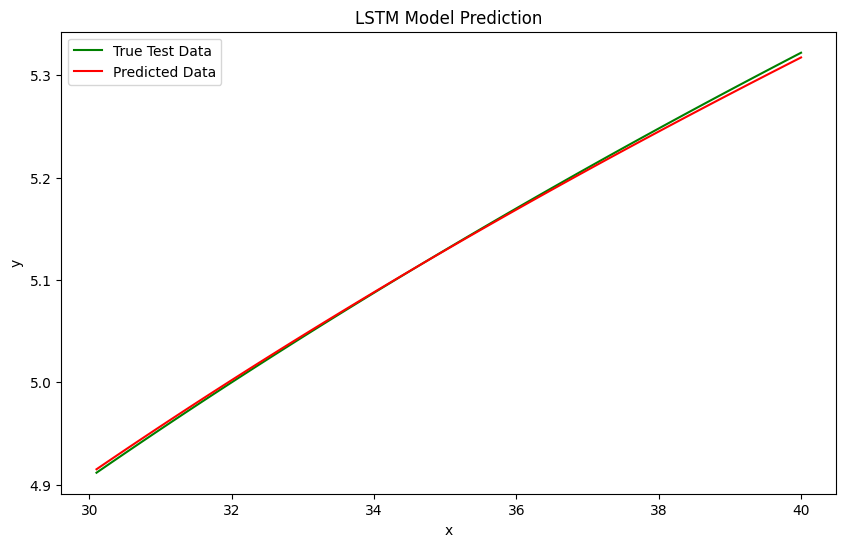

In [6]:
# 绘制结果
plt.figure(figsize=(10, 6))

# 绘制训练数据
# plt.plot(x_train, y_train, label='Training Data', color='blue')

# 绘制测试数据
plt.plot(x_test[sequence_length:], y_test[sequence_length:], label='True Test Data', color='green')

# 绘制预测结果
plt.plot(x_test[sequence_length:], y_pred, label='Predicted Data', color='red')

plt.title('LSTM Model Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()